# Overview of Discrete Metrics
This notebook will provide an overview with examples, of the metrics that will be taken of each datapoint to evaluate effectiveness.

In [93]:
%load_ext autoreload
%autoreload 2

import metrics_calc
from vix_calc_class import vix_calc
from vix_alternative import vix_alternative

import sqlite3
import pandas as pd
pd.set_option('display.precision', 2)

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
DT = '2017-09-29'
d = datetime.strptime(DT, '%Y-%m-%d')

V = vix_alternative()
data, vix = metrics_calc.observe_vix_acc(DT, V)
data.head(3)

,open,close,date_of,date_of_close,annual_,vix_t,price_up,price_down,change_ytd
0,249.15,251.23,2017-09-25,2017-09-29,0.00,0.00,251.23,251.23,0.00
1,251.49,254.37,2017-10-02,2017-10-06,0.02,1.92,256.06,246.40,1.25
2,254.63,254.95,2017-10-09,2017-10-13,0.04,2.72,258.06,244.40,1.48


## A look at implied volatilty as prescribed by the vix over a period of time
The VIX index itself is a standard deviation of the likely change in stock price over the next year. As it is an annualized number, the implied volatility for shorter timeframes can be derived by dividing it by the square root of that given timeframe. Using this method, we can derive the implied volatility for each point along our data.

<br>
The below Figure provides a look at stocks performance over time in blue. 
The orange and green curves represent the bounds for price changes based off the calculated VIX.

VIX for 2017-09-29: 13.88533064782212


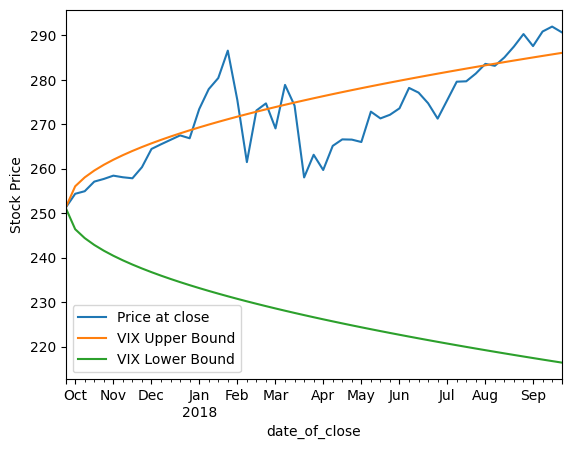

In [107]:
data, VIX = metrics_calc.observe_vix_acc(DT, V)
print(f"VIX for {DT}:", VIX)

# data.rename(columns={"price_up":'VIX_Upper_Bound', 'price_down': 'VIX_Lower_Bound'}, inplace=True)
# data.rename(column={})

ax = data.plot(x='date_of_close', y=['close', 'price_up', 'price_down']);
ax.set_ylabel("Stock Price");
ax.legend(['Price at close', "VIX Upper Bound", "VIX Lower Bound"])
ax.figure.savefig("figures/figure1.png", bbox_inches='tight')


## A look at the absolute change in the SPY (to date), and the prescribed volatility bound
As the VIX is represented using an absolute number, it is also important to look at a stocks absolute change in price over the course of a year.

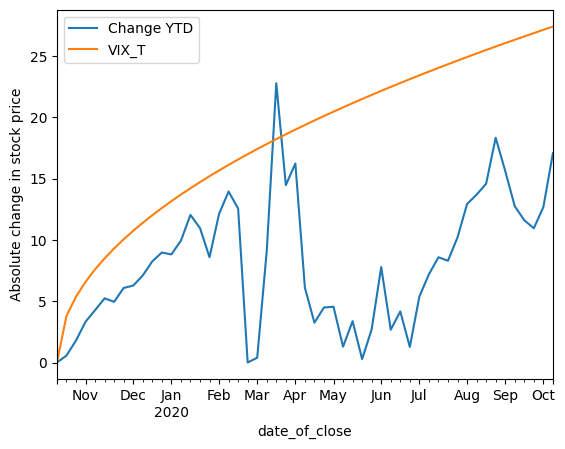

In [96]:
data['change_ytd'] = abs(data.close / data.close.iloc[0] - 1) * 100
ax = data.plot(x='date_of_close', y=['change_ytd', 'vix_t'])
ax.set_ylabel('Absolute change in stock price');
ax.legend(['Change YTD', "VIX_T"])

ax.figure.savefig("figures/figure2.png", bbox_inches='tight')

## 3 ways of measuring effectiveness for a individual period
All Three of these measures will use evaluate the VIX relative to a stocks absolute percentage change for the year.
1. Count how frequently the SPY leaves the vix bounds
3. Take the mean squared error and mean absolute error of the VIX and the real change in stock price.
2. Take the difference between the area under the curve for both indexs.

### Simple Accuracy

According to CBOE, Ideally the VIX should represent 1 standard deviation, of the likely annualized change in stock price. Meaning if the VIX is representive the distribution of a stocks changes, 64.2% of the points should fall within the first bounds.

<br>

The Graph below overlayes a scatter graph of the absolute percentage change of a stock, and a multiline plot illustrating the implied volatility for the first and second standard deviations of the vix, over a 1 year period. In the printouts below, it can be seen that for this sample the vix had a 69.81% accuracy.

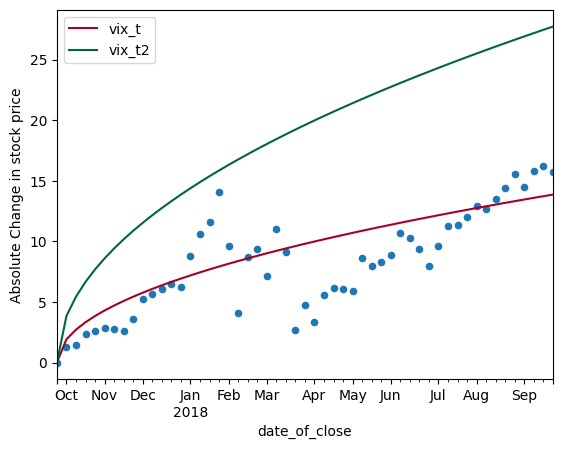

In [87]:
fig, ax = plt.subplots(1, 1);
data['vix_t2'] = data.vix_t * 2

ax = data.plot(x='date_of_close', y=['vix_t', 'vix_t2'], ax=ax, sharex=True, sharey=True, colormap='RdYlGn');
data.plot(x='date_of_close', y='change_ytd', ax=ax, kind='scatter', sharex=True, sharey=True);
ax.set_ylabel("Absolute Change in stock price")

ax.figure.savefig("figures/vix_accuracy.png", bbox_inches='tight')

In [42]:
df = data[['close', 'date_of_close', 'vix_t', 'change_ytd']].copy()

within, exceeded = metrics_calc.calc_accuracy(df, real_col='change_ytd')
print('Within Bound:\t', within)
print('Exceeded bound:\t', exceeded)
print('Accuracy: ', round(within/(within+exceeded)*100, 2))

Within Bound:	 37
Exceeded bound:	 16
Accuracy:  69.81


### Analysing RMSE and MAPE
It may be important to measure the performance of the VIX as a general trendline for absolute change. It is important to note, the VIX does not claim to predict stock prices, just the likely volatility. However as we are looking at the absolute change, regardless of which direction the stock goes, this measure may be useful to weed out irrelevant methods.

In [102]:
metrics.mean_absolute_percentage_error?

Signature:
metrics.mean_absolute_percentage_error(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average',
)
Docstring:
Mean absolute percentage error (MAPE) regression loss.

Note here that the output is not a percentage in the range [0, 100]
and a value of 100 does not mean 100% but 1e2. Furthermore, the output
can be arbitrarily high when `y_true` is small (which is specific to the
metric) or when `abs(y_true - y_pred)` is large (which is common for most
regression metrics). Read more in the
:ref:`User Guide <mean_absolute_percentage_error>`.

.. versionadded:: 0.24

Parameters
----------
y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Ground truth (correct) target values.

y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Estimated target values.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

multioutput : {'raw_values', 'uniform_average'} or array-like
    Defines 

In [43]:
from sklearn import metrics
import math

In [44]:
chg_pct, vix_t_pct = data.change_ytd/100, data.vix_t/100
rmse = round(metrics.mean_squared_error(chg_pct, vix_t_pct, squared=False) * 100, 2)

ape = round(metrics.mean_absolute_percentage_error(data.change_ytd, data.vix_t) * 100, 2)

print(f"Root Mean Squared Error: \t {rmse}")
print(f"Mean Absolute Percentage Error: {ape}")

Root Mean Squared Error: 	 2.74
Mean Absolute Percentage Error: 38.57


### Analysing Curve Areas
To properly assess how to VIX captured the stocks volatility over the course of an entire year. This is done by taking the area of both the VIX for that year, and the real stock price and comparing them. As any measure may both over and undershoot the real value for any individual point of time, the difference between the curved may be an indicated of how one captured the other overall.

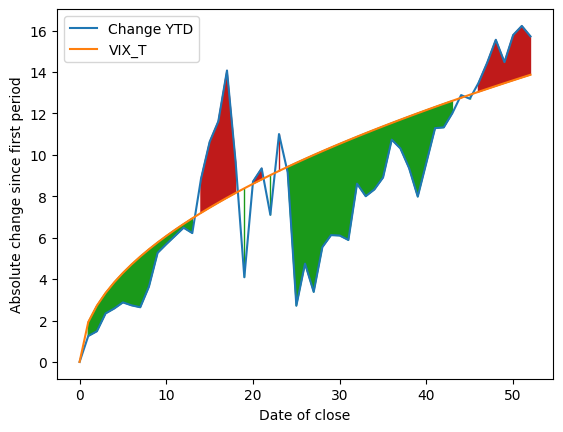

In [97]:
ax = data.plot(y=['change_ytd', 'vix_t'])

ax.legend(['Change YTD', 'VIX_T'])

Y = (data.change_ytd/data.vix_t) > 1
Y2 = (data.change_ytd/data.vix_t) <= 1

ax.fill_between(x=data.index, y1=data.change_ytd, y2=data.vix_t, where=Y, color=(0.75, 0.1, 0.1))
ax.fill_between(x=data.index, y1=data.change_ytd, y2=data.vix_t, where=Y2, color=(0.1, 0.6, 0.1))
# ax.set_xticks(ticks=data.index)
# ax.set_xticklabels(data.date_of_close, minor=False)
ax.set_xlabel("Date of close")
ax.set_ylabel('Absolute change since first period');
ax.figure.savefig("figures/curve_areas.png", bbox_inches='tight')

In [98]:
metrics_calc.aggregate_metrics.agg_metrics(data)

{'accuracy': 0.6981,
 'stddev': 10.805782579494075,
 'auc': 81.9586251686262,
 'aoc': -30.37638039944345,
 'yearopen': 251.23,
 'yearclose': 290.72,
 'yearchange': 15.72,
 'vixtotal': 487.24279486272275}

In [99]:
curve_aoc, curve_auc = metrics_calc.calc_auc_aoc(data, curveA='change_ytd', curveB='vix_t')
print(f"Area under Curve {curve_auc}\nArea Over Curve\t {curve_aoc}")

Area under Curve -30.37638039944345
Area Over Curve	 81.9586251686262


In [100]:
curve_auc + curve_aoc

51.58224476918275